In [3]:
import os
import time
import numpy as np
import pandas
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from shapely.geometry import box
from shapely.ops import unary_union

max_level = 12

g = 0
scale = .1
color_cycle = []
color_cycle += ['black','red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite']
color_cycle += ['cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']


color_border_cycle = ['white', 'yellow', 'red', 'black', 'black', 'black', 'black', 'cyan', 'red']
color_linewidth_cycle =  [0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 1, 0.25, 0.1, 0.25]

use_map_projection = True
show_just_one = False
best_proj_epsg = 5070a

use_exact_bounding_box = True

data_dir = '/home/idies/workspace/Temporary/raddick/hydrography_scratch/'
figdir = '/home/idies/workspace/Storage/raddick/hydrography/figures/'
print('ok')


ok


In [2]:
s = time.time()
print('Reading hydro basins data...')
basins_gdf = geopandas.GeoDataFrame()
for i in range(1, max_level+1):
    print('\tLevel {0:.0f}...'.format(i))
    basins_gdf_i = geopandas.read_file(data_dir+'hydrobasins_with_lakes/hybas_lake_na_lev01-12_v1c/hybas_lake_na_lev{0:02d}_v1c.shp'.format(i))
    basins_gdf_i = basins_gdf_i.assign(LEVEL = i)
    basins_gdf = pandas.concat((basins_gdf, basins_gdf_i), axis=0)

basins_gdf = basins_gdf.set_index('HYBAS_ID')
basins_gdf = basins_gdf[[x for x in basins_gdf.columns if x != 'geometry'] + ['geometry']]
basins_gdf = basins_gdf.sort_values(by='SORT')
max_order = basins_gdf['ORDER'].max()

print('reading from natural earth dataset...')
print('\tgetting oceans...')
#ocean_gdf = geopandas.read_file(data_dir+'natural-earth-vector/50m_physical/ne_50m_ocean.shp')
ocean_gdf = geopandas.read_file(data_dir+'natural-earth-vector/110m_physical/ne_110m_ocean.shp')
#ocean_gdf.index.name = 'uident'

print('\tgetting lakes...')
lakes_gdf = geopandas.read_file(data_dir+'natural-earth-vector/50m_physical/ne_50m_lakes.shp')
#lakes_gdf.loc[:, 'uident'] = pandas.to_numeric(lakes_gdf['uident'], downcast='integer')
#lakes_gdf = lakes_gdf.set_index('uident')

print('intersecting with bounding box...')
if (use_exact_bounding_box):
    bounding_box_gdf = geopandas.GeoDataFrame(data=[[unary_union(basins_gdf[basins_gdf['LEVEL'] == 1].geometry.tolist())]], columns=['geometry'], crs=basins_gdf.crs, geometry='geometry')
else:
    bounding_box_gdf = geopandas.GeoDataFrame(data=[[box(-145,5,-50,65)]], columns=['geometry'], crs=basins_gdf.crs, geometry='geometry')
ocean_here_gdf = geopandas.overlay(ocean_gdf, bounding_box_gdf, how='intersection')
lakes_here_gdf = geopandas.overlay(lakes_gdf, bounding_box_gdf, how='intersection')

#basins_gdf = basins_gdf.sort_values(by=['ORDER', 'SORT'])
e = time.time()
g = g + (e-s)
print('Found {0:,.0f} columns for {1:,.0f} basins in {2:,.0f} minutes {3:,.0f} seconds!'.format(basins_gdf.shape[1], basins_gdf.shape[0], np.floor((e-s)/60), np.floor((e-s)%60)))


Reading hydro basins data...
	Level 1...
	Level 2...
	Level 3...
	Level 4...
	Level 5...
	Level 6...
	Level 7...
	Level 8...
	Level 9...
	Level 10...
	Level 11...
	Level 12...
reading from natural earth dataset...
	getting oceans...
	getting lakes...
intersecting with bounding box...
Found 16 columns for 642,579 basins in 34 minutes 13 seconds!


In [ ]:
# s = time.time()
# for i in range(0,max_order+1):
#     print('Order {0:,.0f} has {1:,.0f} basins...'.format(i, len(basins_gdf[basins_gdf['ORDER'] == i])))

# # Order 0 has 20,844 basins...
# # Order 1 has 101,921 basins...
# # Order 2 has 180,780 basins...
# # Order 3 has 178,558 basins...
# # Order 4 has 108,748 basins...
# # Order 5 has 40,552 basins...
# # Order 6 has 9,674 basins...
# # Order 7 has 1,349 basins...
# # Order 8 has 153 basins...
# e = time.time()
# g = g + (e-s)
# print('Done {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


Max order = 2
plotting oceans and lakes...
Plotting took 30 minutes 40 seconds!


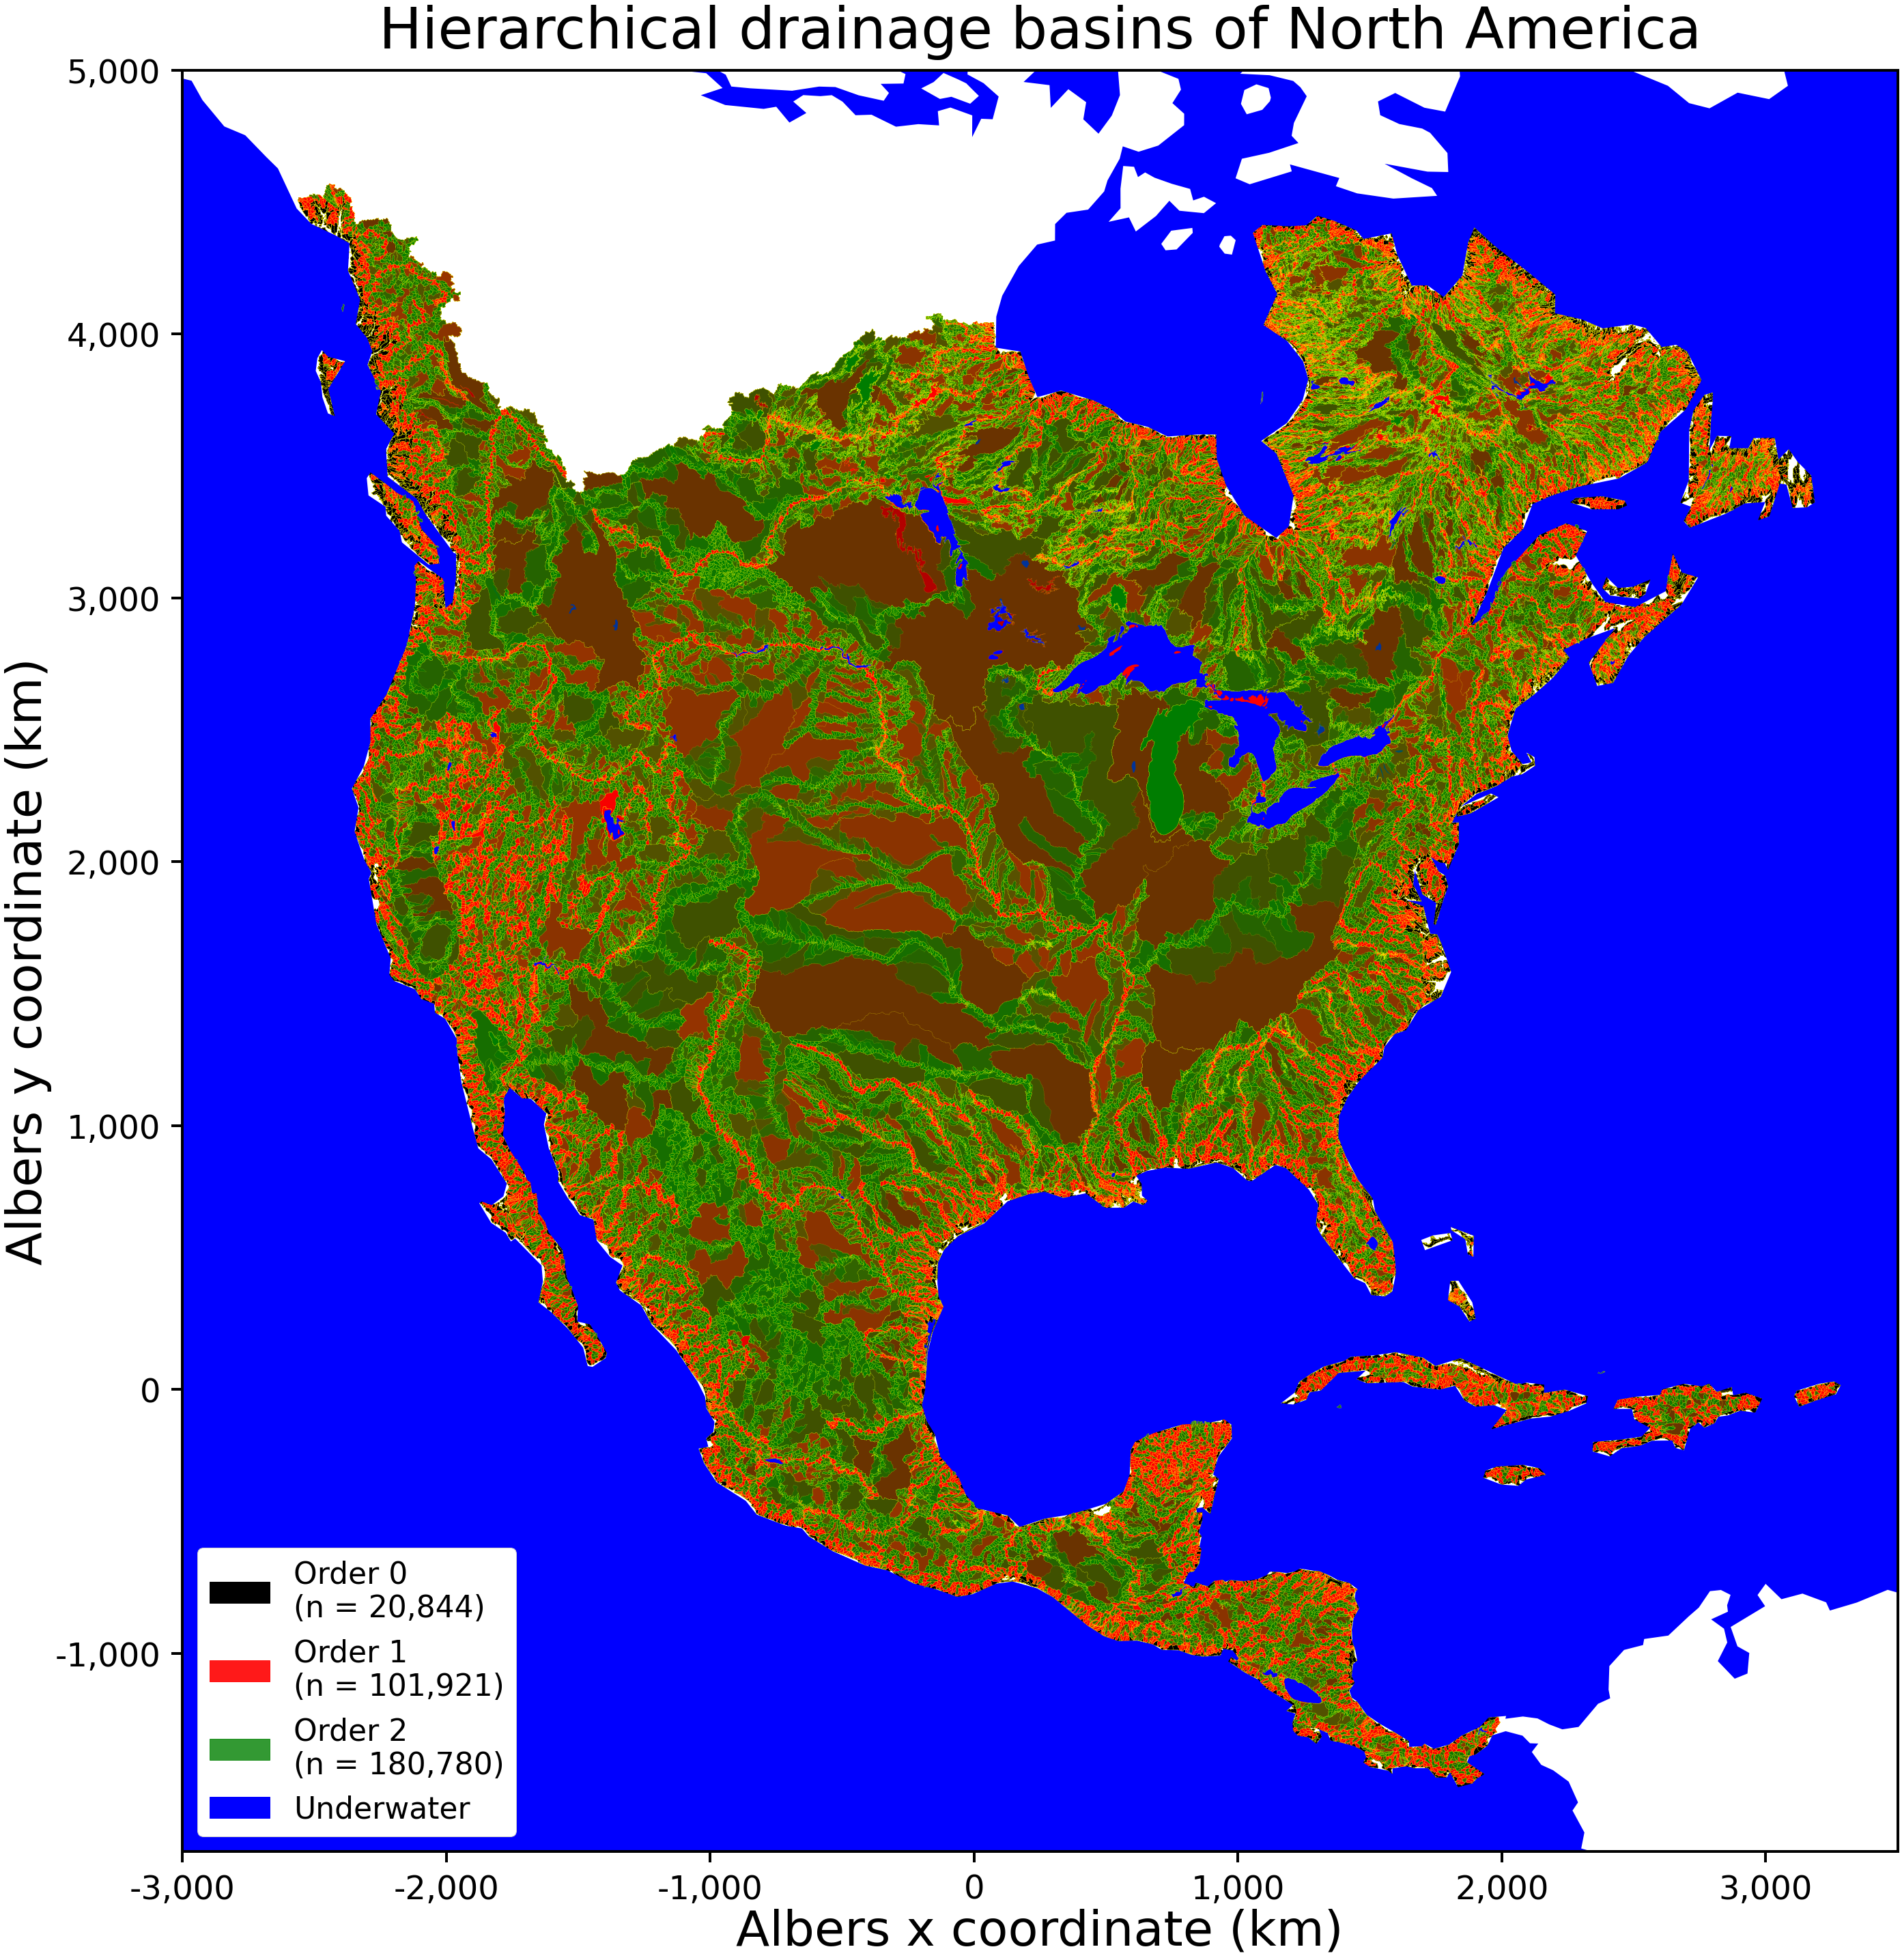

In [6]:
s = time.time()
scale = 1
max_order = 2

if (use_map_projection):
    fig, ax = plt.subplots(1,1,figsize=(48*scale, 48*scale))
else:
    fig, ax = plt.subplots(1,1,figsize=(8*scale,8*scale))

ax.set_aspect('equal')

legend_list = []
print('Max order = {0:,.0f}'.format(max_order))
if (show_just_one):
    for i in range(max_order, max_order+1):
        print('Plotting order {0:,.0f} basins...'.format(i))
        basins_gdf.to_crs(epsg=best_proj_epsg)[(basins_gdf['ORDER'] == i)
                  ].plot(ax=ax, color=color_cycle[i], alpha=1-(i/10), 
                         edgecolor=color_border_cycle[i], lw=color_border_cycle[i])
        legend_list.append(
            mpatches.Patch(color=color_cycle[i], 
                        label='Order {0:}\n(n = {1:,.0f})'.format(i, len(basins_gdf[basins_gdf['ORDER'] == i])),
                        alpha=1-(i/10)))
        if (i <= 3):
            lakes_here_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')
    print('plotting oceans and lakes...')
    ocean_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')       
        
else:
    for i in range(0, max_order+1):
        basins_gdf.to_crs(epsg=best_proj_epsg)[(basins_gdf['ORDER'] == i)
                  ].plot(ax=ax, color=color_cycle[i], alpha=1-(3*i/10), zorder=i, 
                         edgecolor='yellow', lw=0.25)

        legend_list.append(
            mpatches.Patch(color=color_cycle[i], 
                        label='Order {0:}\n(n = {1:,.0f})'.format(i, len(basins_gdf[basins_gdf['ORDER'] == i])),
                        alpha=1-(i/10)))
    print('plotting oceans and lakes...')
    lakes_here_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')
    ocean_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')    
    
legend_list.append(mpatches.Patch(color='blue',label='Underwater'))

if (use_map_projection):
    lege = ax.legend(handles=legend_list, fontsize=44*scale, loc='lower left', facecolor='white', framealpha=1)#, zorder=20)
else:
    lege = ax.legend(handles=legend_list, fontsize=12*scale, loc='upper right', facecolor='white', framealpha=1)#, zorder=20)
lege.set_zorder(20)


#plt.show()

if (use_map_projection):
    ax.set_xlim((-3e6, 3.5e6))
    ax.set_ylim((-1.75e6, 5e6))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4*scale)

    ax.tick_params(axis='both', which='both', size=16*scale, width=4*scale, 
                  labelsize=48*scale, pad=16*scale)

    ax.xaxis.set_major_formatter(lambda x, pos: '{0:,.0f}'.format(x/1000))
    ax.set_xlabel('Albers x coordinate (km)', size=72*scale)

    ax.yaxis.set_major_formatter(lambda y, pos: '{0:,.0f}'.format(y/1000))
    ax.set_ylabel('Albers y coordinate (km)', size=72*scale)
    plt.title('Hierarchical drainage basins of North America', fontsize=84*scale, y=1.01)

else:
    ax.set_xlim((-120,-100))
    ax.set_ylim((30,50))

    
# if (show_just_one):
#     plt.savefig(data_dir+'drainage_na_{0:.0f}_huge.jpg'.format(max_order), format='jpg', dpi=600)
# else:
#     plt.savefig(data_dir+'drainage_na_0_{0:.0f}_huge.jpg'.format(max_order), format='jpg', dpi=600)

e = time.time()
g = g + (e-s)
print('Plotting took {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
plt.show()

In [ ]:
# s = time.time()

# #basins_gdf = basins_gdf.assign(area_sq_km = basins_gdf.to_crs(epsg=best_proj_epsg).geometry.area / 1000000)

# basins_gdf = basins_gdf.assign(name = np.nan)
# basins_gdf.loc[basins_gdf.sort_values(by='SUB_AREA', ascending=False)[0:1].index, 'name'] = 'North America'
# basins_gdf.loc[basins_gdf.sort_values(by='SUB_AREA', ascending=False)[1:2].index, 'name'] = 'MMO'

# basins_gdf = basins_gdf[[x for x in basins_gdf.columns if x != 'geometry'] + ['geometry']]

# basins_gdf_bk = basins_gdf
# e = time.time()
# print(e-s)
# #basins_gdf[basins_gdf.columns[:-1]].head(10)

#ocean_gdf#.sample(3)

In [ ]:
# basins_gdf = basins_gdf_bk
# fig, ax = plt.subplots(1,1)
# #basins_gdf.sort_values(by='SUB_AREA', ascending=False)[1:2]
# basins_gdf[basins_gdf['name'] == 'North America'].plot(ax=ax, color='none', edgecolor='blue', lw=0.5)
# basins_gdf[basins_gdf['name'] == 'MMO'].plot(ax=ax, color='black', edgecolor='yellow')

# plt.show()
# basins_gdf[basins_gdf['name'] == 'MMO'].index

In [ ]:
# s = time.time()
# scale = 1


# fig, ax = plt.subplots(1,1,figsize=(8*scale,8*scale))

# ax.set_aspect('equal')


# legend_list = []
# #print('Max order = {0:,.0f}'.format(max_order))


# # basins_gdf[basins_gdf['ORDER'] == 0].sort_values(by='SUB_AREA').plot(ax=ax)
# print('Plotting order 0...')

# basins_gdf[basins_gdf['ORDER'] == 0].plot(ax=ax, color='none', edgecolor=color_cycle[0], lw=0.25)
# basins_gdf[basins_gdf['ORDER'] == 1].plot(ax=ax, color='none', edgecolor=color_cycle[1], lw=0.25)
# basins_gdf[basins_gdf['ORDER'] == 2].plot(ax=ax, color='none', edgecolor=color_cycle[2], lw=0.25)

# legend_list.append(mpatches.Patch(color=color_cycle[0], label='Order 0 (n = {0:,.0f})'.format(len(basins_gdf[basins_gdf['ORDER'] == 0]))))


# print('Plotting oceans and lakes...')
# lakes_here_gdf.plot(ax=ax, color='blue')
# ocean_here_gdf.plot(ax=ax, color='blue')

# legend_list.append(mpatches.Patch(color='blue',label='Underwater'))

# lege = ax.legend(handles=legend_list, fontsize=12*scale, loc='upper right', facecolor='white', framealpha=1)#, zorder=20)
# lege.set_zorder(20)


# #plt.show()

# ax.set_xlim((-109.03,-102.03))
# ax.set_ylim((37,41))

    
# #plt.savefig(data_dir+'drainage_na_0_{0:.0f}_huge.svg'.format(max_order), format='svg')
# plt.savefig(data_dir+'drainage_na_0_{0:.0f}_huge.jpg'.format(max_order), format='svg')

# e = time.time()
# g = g + (e-s)
# print('Plotting took {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
# plt.show()

In [9]:
s = time.time()
colorado_geo_gdf = geopandas.GeoDataFrame(data=[
    [box(-109.03,37,-102.03,41)]
], columns=['geometry'], crs=basins_gdf.crs,
                       geometry='geometry')
colorado_basins_gdf = geopandas.overlay(basins_gdf, colorado_geo_gdf, 
                  how='intersection')
e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


Done in 18 minutes 57 seconds!


In [15]:
s = time.time()
use_exact_bounding_box = False
print('\tgetting lakes...')
lakes_gdf = geopandas.read_file(data_dir+'natural-earth-vector/50m_physical/ne_50m_lakes.shp')

print('intersecting with bounding box...')
if (use_exact_bounding_box):
    bounding_box_gdf = geopandas.GeoDataFrame(data=[[unary_union(colorado_basins_gdf[colorado_basins_gdf['LEVEL'] == 1].geometry.tolist())]], columns=['geometry'], crs=colorado_basins_gdf.crs, geometry='geometry')
else:
    bounding_box_gdf = geopandas.GeoDataFrame(data=[[box(-109.03,37,-102.03,41)]], columns=['geometry'], crs=colorado_basins_gdf.crs, geometry='geometry')
ocean_here_gdf = geopandas.overlay(ocean_gdf, bounding_box_gdf, how='intersection')
lakes_here_gdf = geopandas.overlay(lakes_gdf, bounding_box_gdf, how='intersection')
e = time.time()
g = g + (e-s)
print('Done in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))


	getting lakes...
intersecting with bounding box...
Done in 0 minutes 1 seconds!


Max order = 7
Plotting took 4 minutes 9 seconds!


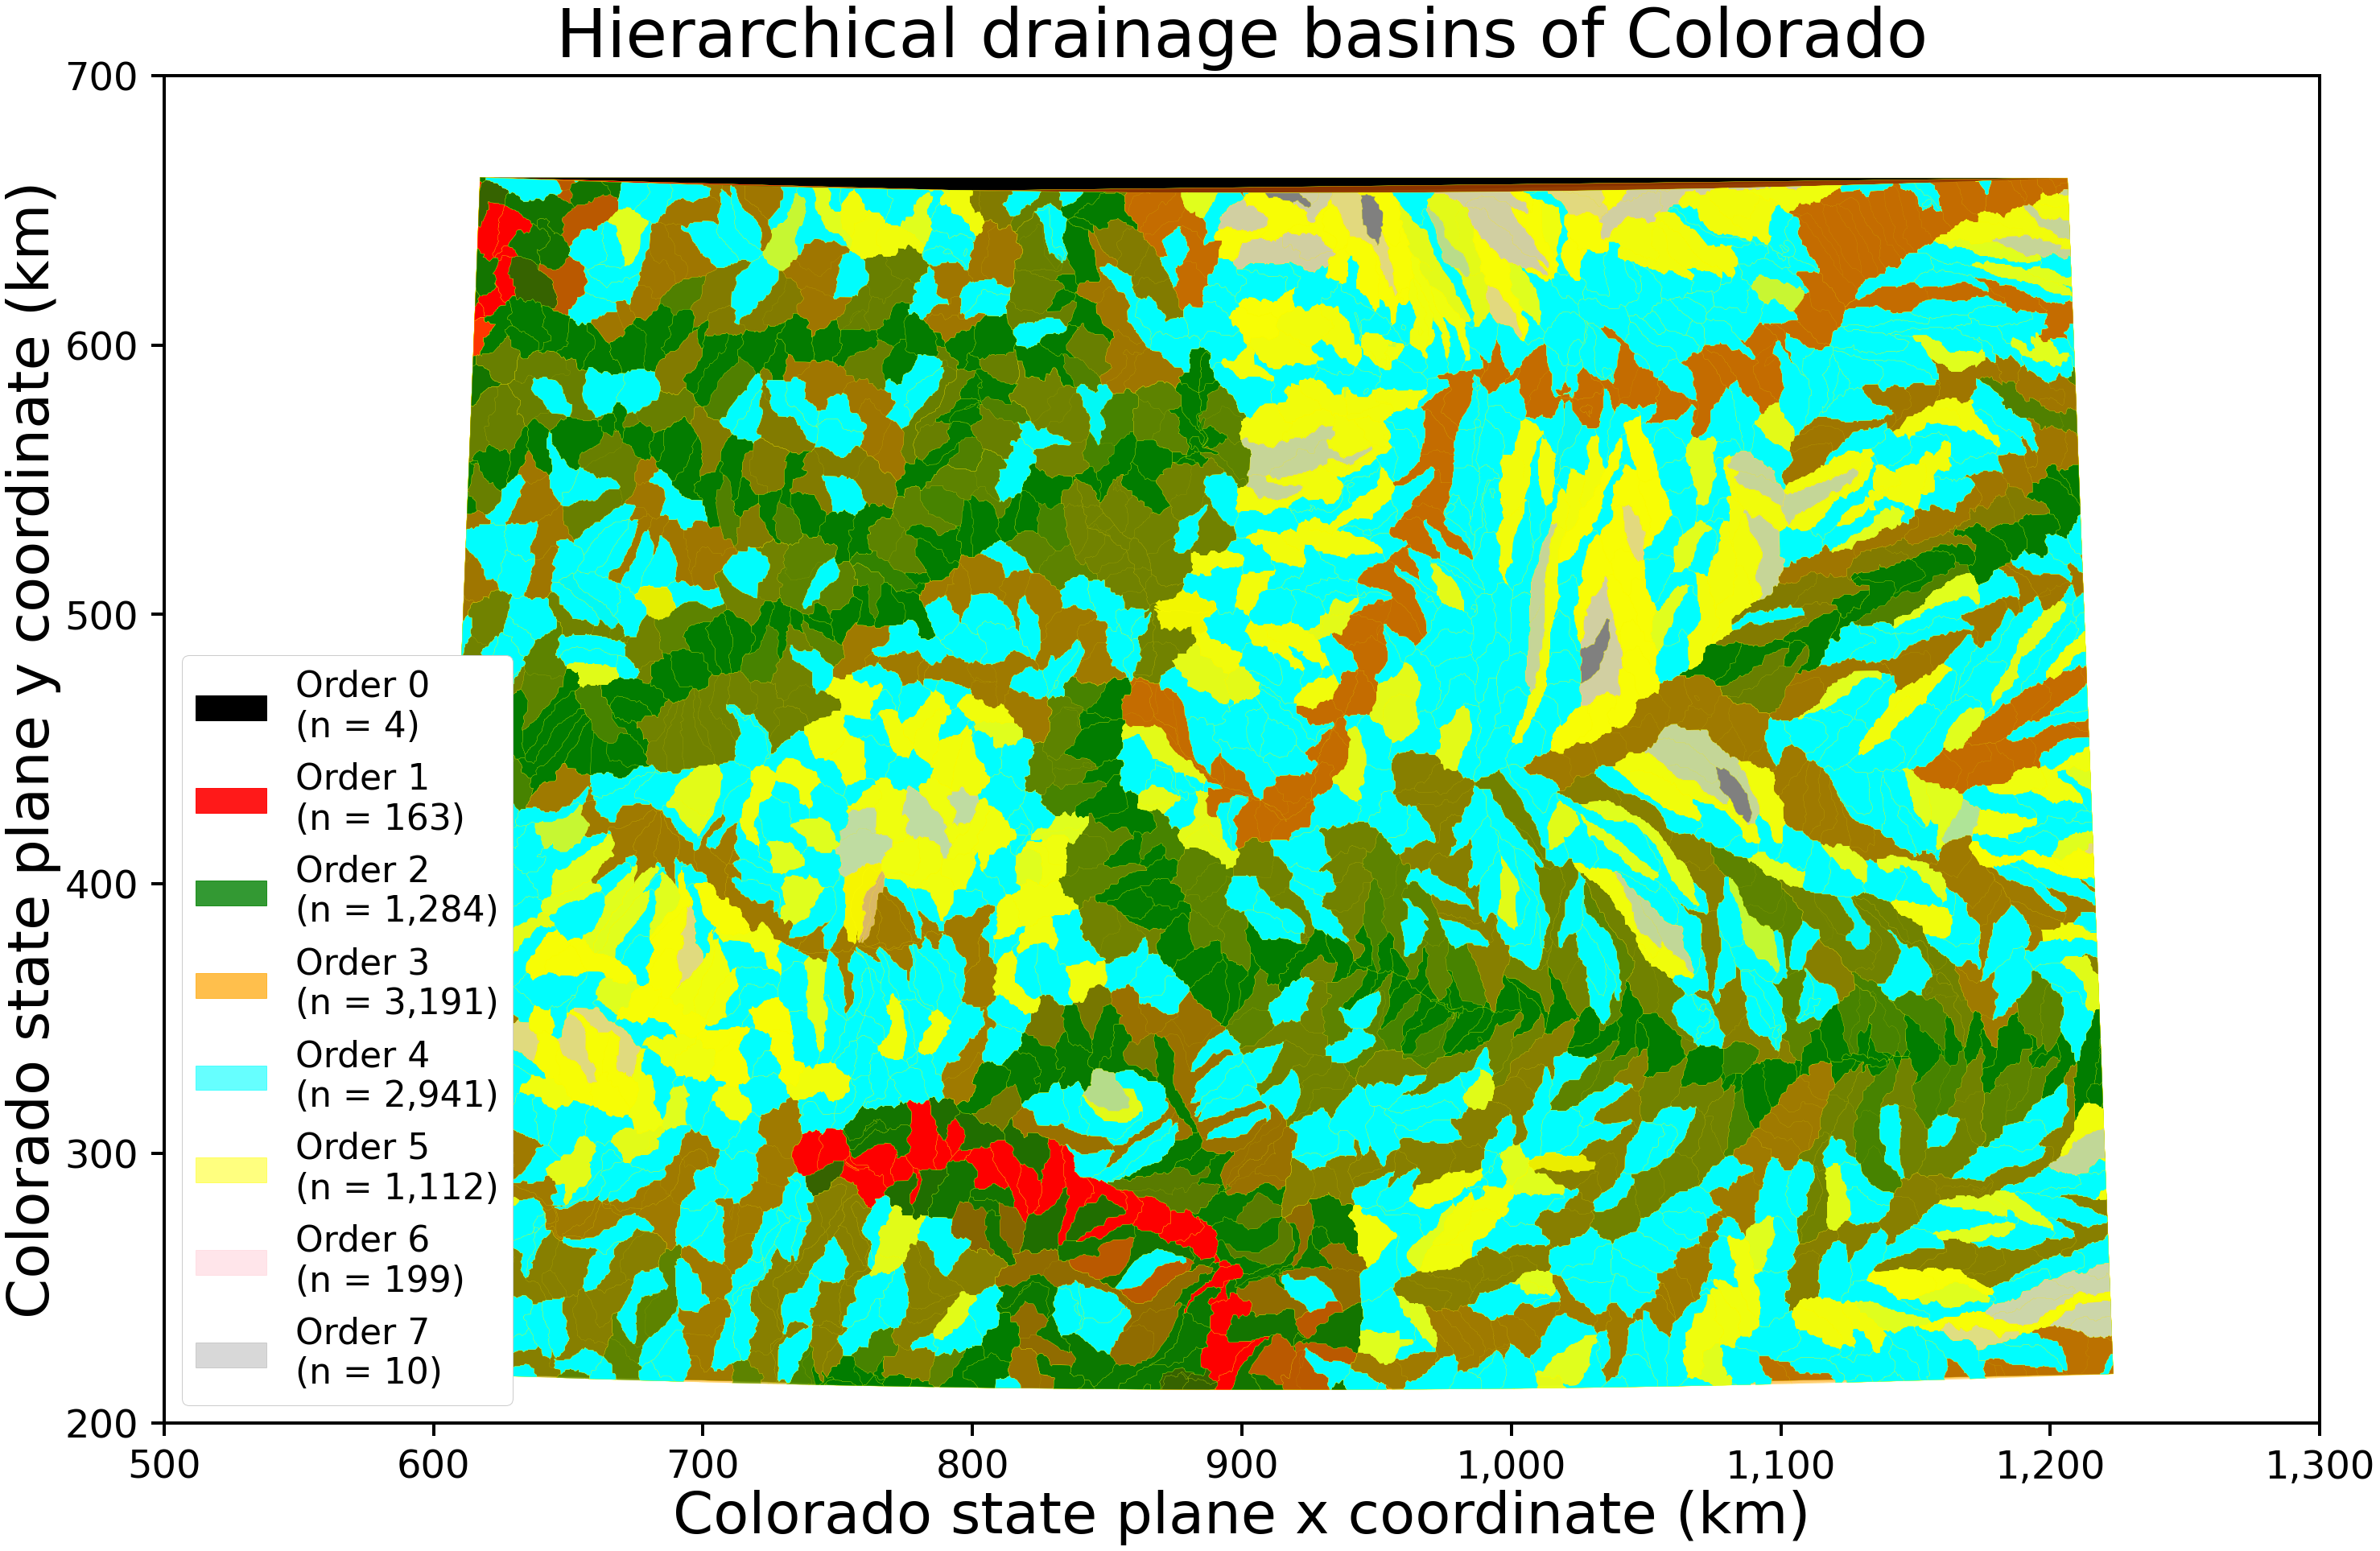

In [26]:
s = time.time()
scale = 1
max_order = 7
best_proj_epsg = 3501
show_just_one = False

if (use_map_projection):
    fig, ax = plt.subplots(1,1,figsize=(48*scale, 48*scale))
else:
    fig, ax = plt.subplots(1,1,figsize=(8*scale,8*scale))

ax.set_aspect('equal')

legend_list = []
print('Max order = {0:,.0f}'.format(max_order))
if (show_just_one):
    for i in range(max_order, max_order+1):
        print('Plotting order {0:,.0f} basins...'.format(i))
        colorado_basins_gdf.to_crs(epsg=best_proj_epsg)[(colorado_basins_gdf['ORDER'] == i)
                  ].plot(ax=ax, color=color_cycle[i], alpha=1-(i/10), 
                         edgecolor=color_border_cycle[i], lw=color_border_cycle[i])
        legend_list.append(
            mpatches.Patch(color=color_cycle[i], 
                        label='Order {0:}\n(n = {1:,.0f})'.format(i, len(colorado_basins_gdf[colorado_basins_gdf['ORDER'] == i])),
                        alpha=1-(i/10)))
#         if (i <= 3):
#             lakes_here_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')
#     print('plotting oceans and lakes...')
    #ocean_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')       
        
else:
    for i in range(0, max_order+1):
        colorado_basins_gdf.to_crs(epsg=best_proj_epsg)[(colorado_basins_gdf['ORDER'] == i)
                  ].plot(ax=ax, color=color_cycle[i], alpha=1-(3*i/10), zorder=i, 
                         edgecolor='yellow', lw=0.25)

        legend_list.append(
            mpatches.Patch(color=color_cycle[i], 
                        label='Order {0:}\n(n = {1:,.0f})'.format(i, len(colorado_basins_gdf[colorado_basins_gdf['ORDER'] == i])),
                        alpha=1-(i/10)))
#     print('plotting oceans and lakes...')
#     lakes_here_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')
#    ocean_gdf.to_crs(epsg=best_proj_epsg).plot(ax=ax, color='blue')    
    
#legend_list.append(mpatches.Patch(color='blue',label='Underwater'))

if (use_map_projection):
    lege = ax.legend(handles=legend_list, fontsize=44*scale, loc='lower left', facecolor='white', framealpha=1)#, zorder=20)
else:
    lege = ax.legend(handles=legend_list, fontsize=12*scale, loc='upper right', facecolor='white', framealpha=1)#, zorder=20)
lege.set_zorder(20)


#plt.show()

if (use_map_projection):
    ax.set_xlim((500000, 1300000))
    ax.set_ylim((200000,700000))
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4*scale)

    ax.tick_params(axis='both', which='both', size=16*scale, width=4*scale, 
                  labelsize=48*scale, pad=16*scale)

    ax.xaxis.set_major_formatter(lambda x, pos: '{0:,.0f}'.format(x/1000))
    ax.set_xlabel('Colorado state plane x coordinate (km)', size=72*scale)

    ax.yaxis.set_major_formatter(lambda y, pos: '{0:,.0f}'.format(y/1000))
    ax.set_ylabel('Colorado state plane y coordinate (km)', size=72*scale)
    plt.title('Hierarchical drainage basins of Colorado', fontsize=84*scale, y=1.01)

else:
    ax.set_xlim((-120,-100))
    ax.set_ylim((30,50))

    
if (show_just_one):
    plt.savefig(data_dir+'drainage_colorado_{0:.0f}_huge.jpg'.format(max_order), format='jpg', dpi=600)
else:
    plt.savefig(data_dir+'drainage_colorado_0_{0:.0f}_huge.jpg'.format(max_order), format='jpg', dpi=600)

e = time.time()
g = g + (e-s)
print('Plotting took {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), np.floor((e-s)%60)))
plt.show()